In [1]:
import math
from reservoirpy.nodes import Reservoir, Ridge
import reservoirpy as rpy
import numpy as np
import matplotlib.pyplot as plt

from reservoirpy.observables import mse, nrmse, rmse
from statistics import mean


rpy.verbosity(0)#Not sure what these 2 commands do 
rpy.set_seed(42)  

In [2]:
#The purpose of the class is to process data from the OHIOT1D data set
class Data_Processor:
    
    
    #initializes any starting data members
    def __init__(self, read_file_path):
        #File path is read in from constructor
        self.file_path = read_file_path

        #raw_date_time_array contain dates and times, raw_glucose_level_array contains glucose level
        self.raw_date_time_array = []
        self.raw_glucose_level_array = [] 

        self.complete_time_set = [[]] #this array holds all 24 hour time cycles; it is a 2 dimensional array
        # - each index represents a day (24 hour cycle), contains an array
        # - each index of 2nd array is a time cycle
        self.complete_glucose_set = [[]] #this array holds all glucose values. Each index is 24 hr cycle array containing different glucose values
        self.complete_set_index = 0 #This represents the current index in the complete_set arrays 


        #these contain small amounts of data that will be loaded into the complete time set
        self.short_current_date = []
        self.possible_next_day = []
        pass



    #_____________________________________________________________________________________________________________________________________
    #1. Stores all raw time and glucose data into separate arrays
    def Read_Raw_Data(self):
        import xml.etree.ElementTree as ET

        tree = ET.parse(self.file_path)

        root = tree.getroot()

        
        for data_point in root[0]:
            data_point_dict = data_point.attrib#each attribute is a dictionary
            self.raw_date_time_array.append(data_point_dict.get("ts"))
            self.raw_glucose_level_array.append(int(data_point_dict.get("value")))
            pass

        #Check to see if data correctly read in 
        #print(data_time_array[0], data_time_array[len(data_time_array) - 1])
        #print("Hi:",self.raw_glucose_level_array[0])
        pass



    #_____________________________________________________________________________________________________________________________________
    #2. Converts time into 24 hour cycle and converts glucose to integer, Inserts any missing data values into time and glucose arrays
    def Process_Raw_Data(self):

        set_size = len(self.raw_date_time_array)
        

        #print(self.raw_date_time_array[0])#19-05-2027 11:36:29
        previous_split_set = self.raw_date_time_array[0].split(' ')
        prev_glucose = self.raw_glucose_level_array[0]
        index = 1
        #This loop sends processes and adds each set of glucose and time values one at at time to the complete_sets iteratively 
        while index < set_size:
            current_split_set = self.raw_date_time_array[index].split(' ')
            newest_glucose = self.raw_glucose_level_array[index]
            
            #NEW_DATE_FUNC call to generate new short_time_arrays
            new_day_flag = self.__new_date_func(current_split_set, previous_split_set)
            #ADD_TO_COMPLETE_SETS call to add short_time_array content to complete_set arrays
            self.__add_to_complete_sets(new_day_flag, prev_glucose, newest_glucose)

            previous_split_set = current_split_set
            prev_glucose = newest_glucose
            index += 1
            pass
        #"""
        pass
    


    #______________________________________________________________________________________________________________________________________
    #3. Adds data to complete_data_sets from the short_time_arrays and also fills in corresponding values in the glucose_array
    def __add_to_complete_sets(self, new_day_flag, prev_glucose, newest_glucose):
        
        #the if statement gets rid of copies in both complete_sets  
        last_value = len(self.complete_time_set[self.complete_set_index]) - 1
        if (last_value > -1 and (self.short_current_date[0] == self.complete_time_set[self.complete_set_index][last_value])):     
            del(self.complete_time_set[self.complete_set_index][-1])
            del(self.complete_glucose_set[self.complete_set_index][-1])
            pass


        self.complete_time_set[self.complete_set_index].extend(self.short_current_date)

        #Adding values to the complete_glucose_set 
        self.complete_glucose_set[self.complete_set_index].append(prev_glucose)
        
        no_glucose_to_add = len(self.short_current_date) - 2
        #This loop adds middle glucose values to complete_glucose_array
        i = 1
        while i <= no_glucose_to_add:
            temp = prev_glucose + ((newest_glucose - prev_glucose) * (i / (no_glucose_to_add + 1)))
            self.complete_glucose_set[self.complete_set_index].append(temp)
            i += 1 
            pass

        #if the new day flag is set, then complete_set_index is incremented and values in possible_next_day are added to the complete_time_set
        if (new_day_flag):
            self.complete_set_index += 1
            self.complete_time_set.append(self.possible_next_day)
            self.complete_glucose_set.append([newest_glucose])
            pass
        else:
            self.complete_glucose_set[self.complete_set_index].append(newest_glucose)
        #add final glucose value to complete_set
        

        pass  
    
   
    #______________________________________________________________________________________________________________________________________
    #4. Call func that creates short_time arrays from Prev and Current
    def __new_date_func(self, current, prev):
        #Converting current and previous to date values
        previous_day = prev[0]
        previous_time = prev[1]
        current_day = current[0] 
        current_time = current[1]
    
        prev_exact_date = int(previous_day.split('-')[0])#ex date: 19-05-2027 (19 is the date)
        current_exact_date = int(current_day.split('-')[0]) 


        #Checking if dates are the same or different
        if prev_exact_date == current_exact_date:
            new_date_flag = False
        else:
            new_date_flag = True
            #set day_seg then return it
        
        #Call to Time Process function 
        self.short_current_date, self.possible_next_day = self.__time_process_func(previous_time, current_time, new_date_flag)



        return new_date_flag
        pass


    #_____________________________________________________________________________________________________________________________________
    #5. Converts previous and current time values into integer values placed in short_time arrays
    def __time_process_func(self, previous_time, current_time, new_date_flag):    
        #storing current and previous minute and sec values
        temp_time_array = previous_time.split(':')
        prev_hour = int(temp_time_array[0])*60 #converted to minute
        prev_minute = int(temp_time_array[1])
        prev_second = int(temp_time_array[2])/60 #converted to fraction of minute
        prev_time = prev_minute + prev_second + prev_hour 
        
        temp_time_array = current_time.split(':')
        current_hour = int(temp_time_array[0])*60 #converted to minute
        current_minute = int(temp_time_array[1]) 
        current_second = int(temp_time_array[2])/60 #converted to fracton of minute
        current_time = current_minute + current_second + current_hour

        
        #If the time is within the 5 time mark
        #may be used if new_day_flag is sef if ((current_time <= prev_time + 5 and prev_time + 5 <= 60) or (prev_time + 5 > 60 and current_time + 60 <= prev_time + 5)):
        
        #If the new_date_flag is set to false
        if(new_date_flag == False):
            possible_next_day = []
            short_current_date = [prev_time] #holds new time set
            #
            if (current_time <= prev_time + 5):
                pass
            
            #If the time is beyond the 5 time mark, append to the middle of the short_time array
            else:
                no_added_data_points = math.ceil((current_time - prev_time)/5)
                dividing_factor = no_added_data_points + 1

                for i in range(no_added_data_points):
                    short_current_date.append(prev_time +((current_time - prev_time)* ((i + 1) / dividing_factor)))
                    pass

            short_current_date.append(current_time)

        #if new_date_flag set to true start next day 24 hour cycle exactly where the current time starts, don't add any more times between
        if(new_date_flag == True):
            short_current_date = [prev_time]
            possible_next_day = [current_time]
            pass

        return short_current_date, possible_next_day

    
    #_____________________________________________________________________________________________________________________________________
    #6. USED TO TEST PROGRAM: Graphs and shows data associated with a single day of CGM data   
    def Graph_Single_Date(self):
        import matplotlib.pyplot as plt

        day = 0

        no_points_in_day = len(self.complete_time_set[day])

        #scaling x axis to hours
        x_axis = []
        for i in range(no_points_in_day):
            x_axis.append(self.complete_time_set[day][i]/60)
            pass

        y_axis = self.complete_glucose_set[day]

        
        print("day: ",day)
        print("day time:", self.complete_time_set[day][150]/60)
        print("glucose level:", self.complete_glucose_set[day][150])
        print("# points: ", no_points_in_day)
        plt.plot(x_axis, y_axis)
        plt.show()
        pass
        

In [3]:
class Single_Training_Group:

    #initializes any starting data members: creates Filter_Data used to Train and Test the reservoir, creates the basic reservoir structure
    def __init__(self, group_size, filter_data, no_epochs):

        #Connects the Reservoir to the Readout
        self.reservoir = Reservoir(500, lr=0.5, sr=0.5)
        self.readout = Ridge(ridge=1e-7)
        self.esn_model = self.reservoir >> self.readout

        self.no_epochs = no_epochs  #used to determine length of training
        self.training_set_length = group_size  #stores number of days in training set
        

        #create training_set and testing_validation_set
        self.filter_data = filter_data #only used to create training_sets, not changed in any way
        self.training_set, self.testing_validation_set = self.Build_Single_Training_Set(group_size)

        self.rmse_score = []
        self.final_prediction_error_set = []
        pass       

#The Build_Single_Training_Set function is called by the initializer to build a single training set
#___________________________________________________________________________________________________________________________________________________________________
   
    #called to Build a single training set by the initializer
    def Build_Single_Training_Set(self, group_size):    
    
        training_set = []
        test_validation_data = []
        #training_set = self.filter_data[0]
        #test_validation_data = self.filter_data[1]

        #print(self.filter_data[1])

        add_index = 0
        half_of_data_len = len(self.filter_data)/2 #used instead of hard coding 23

        while (len(test_validation_data) < half_of_data_len):
            test_validation_data.append(self.filter_data[1 + add_index])

            if(len(training_set) < group_size):
                training_set.append(self.filter_data[add_index])
                pass

            add_index += 2
            pass

        return training_set, test_validation_data
#___________________________________________________________________________________________________________________________________________________________________
   

    #Training a Reservoir with the corresponding Training_Set
    def Train(self):

        horizon = 1  # horizon p of the forecast (predict X[t+p] from X[t])
        div_factor = 154.0000 #max value on day 0
        current_epoch = 0 #used to track current epoch

        while current_epoch < self.no_epochs:
            
            for day in self.training_set:

                for partial_daily_glucose in day:
                    
                    partial_daily_points = len(partial_daily_glucose)
                    end_point = partial_daily_points - 2

                    numpy_partial_daily_glucose = np.asfarray(partial_daily_glucose)
                    numpy_partial_daily_glucose = numpy_partial_daily_glucose.reshape((partial_daily_points, 1))

                    for i in range(partial_daily_points):
                        numpy_partial_daily_glucose[i][0] = numpy_partial_daily_glucose[i][0] / 154
                        #print(numpy_partial_daily_glucose[i][0])
                        pass

                    train_start = 0
                    X_train = numpy_partial_daily_glucose[train_start: end_point]
                    y_train = numpy_partial_daily_glucose[horizon + train_start: end_point + horizon]

                    #training function
                    self.esn_model = self.esn_model.fit(X_train, y_train, warmup=2)
                    pass

                pass

            current_epoch += 1
            pass

        return

        

    def Test(self):
        div_factor = 154.0000 #max value on day 0

        for day in self.testing_validation_set:
        #day = self.testing_validation_set[0]    used for testing purposes

            predicted_vs_actual_flag = True #flag for printing Actual vs. Predicted Values

            for partial_daily_glucose in day:
                
                partial_daily_points = len(partial_daily_glucose)
                end_point = partial_daily_points - 2

                numpy_partial_daily_glucose = np.asfarray(partial_daily_glucose)
                numpy_partial_daily_glucose = numpy_partial_daily_glucose.reshape((partial_daily_points, 1))

                for i in range(partial_daily_points):
                    numpy_partial_daily_glucose[i][0] = numpy_partial_daily_glucose[i][0] / 154
                    pass

                train_start = 0
                X_test = numpy_partial_daily_glucose[0: end_point]
                Y_test = numpy_partial_daily_glucose[1:end_point + 1]
                Y_pred = self.esn_model.run(X_test)

                plot_X_test = []
                plot_Y_test = []
                plot_Y_pred = []
                for i in range(len(X_test[1:end_point])):
                    plot_X_test.append(X_test[i] * 154.00)
                for i in range(len(Y_test)):
                    plot_Y_test.append(Y_test[i] * 154.00)
                for i in range(len(Y_pred)):
                    plot_Y_pred.append(Y_pred[i] * 154.00)


                #Only print if epochs = 1, and training set size is 7
                if (self.no_epochs == 2 and self.training_set_length == 7 and predicted_vs_actual_flag == True):
                    plt.figure(figsize=(10, 3))
                    plt.title("Predicted Glucose Levels vs Actual Glucose Levels")
                    plt.xlabel("Time intervals (each interval is 5 min)")
                    plt.ylabel("Glucose Level (mg/dL)")


                    #plt.plot(plot_X_test, label="Actual Glucose Levels", color="blue")
                    plt.plot(plot_Y_test, label="Actual Glucose Levels", color="cyan") #use only this for now
                    plt.plot(plot_Y_pred, label="Predicted Glucose Levels", color="red")
                    plt.legend()
                    plt.show()

                    #Does not work
                    #x_axis = np.arange(0, (5 * (len(X_test))), 5)
                    #x_axis = x_axis.reshape(0,(len(x_axis)))

                    #plt.plot(x_axis, X_test[1:end_point].reshape((0, (len(X_test[1:end_point])))), label="Actual Glucose Levels", color="blue")
                    #plt.plot(x_axis, Y_test[end_point:end_point + 1].reshape((0, (len(Y_test[end_point:end_point + 1])))), label="Final Actual Glucose Level", color="cyan")
                    #plt.plot(x_axis, Y_pred.reshape((0, (len(Y_pred)))), label="Predicted Glucose Levels", color="red")

                    predicted_vs_actual_flag == False #Reset after 1st day of data
                    pass
                    


                self.rmse_score.append(rmse(Y_test, Y_pred))
                self.final_prediction_error_set.append((abs(Y_pred[-1] - Y_test[-1])/Y_test[-1]) * 100.0)
                pass

            return (sum(self.rmse_score) / len(self.rmse_score)), (sum(self.final_prediction_error_set) / len(self.final_prediction_error_set))
            pass
        
        return
   
   

In [4]:
class All_Pt_Training_Groups:

    #Initializes All_Pt_Training_Groups: filters data set, creates all training_data_sets and associated reservoir computers
    def __init__(self, complete_time_set, complete_glucose_set):

        #data is filtered by Data_Filter function 
        self.filter_data = self.Data_Filter_Short(complete_time_set, complete_glucose_set)

        #create Single_Training_Group objects
        epoch_setter = 1

        self.Train_1day = []
        self.Train_2day = []
        self.Train_7day = []
        self.Train_23day = []
        
        #Creates array of training_sets, each training_set in an array has a different number of epochs
        #6
        while epoch_setter < 6:
            self.Train_1day.append(Single_Training_Group(1, self.filter_data, epoch_setter))
            self.Train_2day.append(Single_Training_Group(2, self.filter_data, epoch_setter))
            self.Train_7day.append(Single_Training_Group(7, self.filter_data, epoch_setter))
            self.Train_23day.append(Single_Training_Group(23, self.filter_data, epoch_setter))

            epoch_setter += 1
            pass

        pass

#Filters complete glucose set based on complete_time_set values
#___________________________________________________________________________________________________________________________________________________________________
    #Called by the init function to filter the complete glucose sets into sets between 1 to 2.5 hours.
    def Data_Filter_Short(self, time_set, glucose_set):

        inc_filter_data = []

        total_no_days = len(time_set)

        day = 0

        #This loop loops through all days
        while day < total_no_days:

            check_time_set = time_set[day]
            current_glucose_set = glucose_set[day]

            set_len = len(check_time_set) - 1
            inc_filter_data.append([])#append filter_data with an empty array


            i_time = 0 #iterates through time intervals in a day
            hold_point = 0 
            usable_counter = 0 #used to count until what index is usable

            #This loop iterates through each day's time intervals
            while i_time < set_len:
                if (check_time_set[i_time+1] - check_time_set[i_time]  == 5):
                    usable_counter += 1
                    pass
                else:
                    #used to check if enough usable data has been stored
                    if(usable_counter >= 20):
                        inc_filter_data[day].append(current_glucose_set[hold_point:i_time])

                    else: 
                        #print("index", i_time, "and", i_time + 1, "is not usable")
                        pass
                    
                    usable_counter = 0 #reset 
                    hold_point = i_time + 1
                    pass

                i_time += 1
                pass

            day += 1
            pass
        return inc_filter_data

    #Empty function: will be developed when needed 
    def Data_Filter_Long():
        pass
#___________________________________________________________________________________________________________________________________________________________________


    def Train_All(self):
        
        epoch_index = 0 
        print("In training set")
        while epoch_index < 5:
            #5

            self.Train_1day[epoch_index].Train()
            print("done")
            self.Train_2day[epoch_index].Train()
            print("done")
            self.Train_7day[epoch_index].Train()
            print("done")
            self.Train_23day[epoch_index].Train()
            print("done")

            print("Training with ", epoch_index + 1, "epoch complete")
            epoch_index += 1
            
            pass
        
        return

    def Test_All(self):

        epoch_index = 0 
        rmse_1_set = []
        rmse_2_set = []
        rmse_7_set = []
        rmse_23_set = []
        
        error_1_set = []
        error_2_set = []
        error_7_set = []
        error_23_set = []

        while epoch_index < 5:

            average_rmse_1, average_error_1 = self.Train_1day[epoch_index].Test()
            average_rmse_2, average_error_2 = self.Train_2day[epoch_index].Test()
            average_rmse_7, average_error_7 = self.Train_7day[epoch_index].Test()
            average_rmse_23, average_error_23 = self.Train_23day[epoch_index].Test()

            rmse_1_set.append(average_rmse_1)
            error_1_set.append(average_error_1)
            rmse_2_set.append(average_rmse_2)
            error_2_set.append(average_error_2)
            rmse_7_set.append(average_rmse_7)
            error_7_set.append(average_error_7)
            rmse_23_set.append(average_rmse_23)
            error_23_set.append(average_error_23)

            epoch_index += 1
            pass

        

        x_axis = [1,2,3,4,5]

        plt.figure(figsize=(10, 3))
        plt.title("Percent Error of Predictions from Reservoirs Trained with Different Sets")
        plt.xlabel("Number of Epochs")
        
        plt.ylabel("Percent Error")
        plt.plot(x_axis, error_1_set, label="1_Day", color="blue")
        plt.plot(x_axis, error_2_set, label="2_Day", color="red")
        plt.plot(x_axis, error_7_set, label="7_Day", color="green")
        plt.plot(x_axis, error_23_set, label="23_Day", color="purple")

        plt.xticks([1,2,3,4,5])
        plt.legend()
        plt.show()

        plt.figure(figsize=(10, 3))
        plt.title("Root Mean Squared Error of Predictions from Reservoirs Trained with Different Sets")
        plt.xlabel("Number of Epochs")
        
        plt.ylabel("Root Mean Square Error")
        plt.plot(x_axis, rmse_1_set, label="1_Day", color="blue")
        plt.plot(x_axis, rmse_2_set, label="2_Day", color="red")
        plt.plot(x_axis, rmse_7_set, label="7_Day", color="green")
        plt.plot(x_axis, rmse_23_set, label="23_Day", color="purple")

        plt.xticks([1,2,3,4,5])
        plt.legend()
        plt.show()

        print("\n\nRMSE_7_2epoch: ", rmse_7_set[1])
        print("error_7_2epoch: ", error_7_set[1])



        """
        print("\n\n1 Epoch:\n")
        print("1_day set_length:\tav_rmse: ", average_rmse_1,"\tav_error:", average_error_1)
        print("2_day set_length:\tav_rmse: ", average_rmse_2,"\tav_error:", average_error_2)
        print("7_day set_length:\tav_rmse: ", average_rmse_7,"\tav_error:", average_error_7)
        print("23_day set_length:\tav_rmse: ", average_rmse_23,"\tav_error:", average_error_23)
        print("\n\n\n___________________________________________________________________________________________\n\n")
        """
        

In [5]:
class Train_Pt_2_Reservoir:

    #initializer function: sets number of epochs, training_length, arrays for creating graph
    def __init__(self, complete_time_set, complete_glucose_set):

        self.filter_data = self.Data_Filter_Short(complete_time_set, complete_glucose_set)

        self.epoch_setter = 2
        self.train_len = 7

        self.pt2_train_group = Single_Training_Group(7, self.filter_data, self.epoch_setter)

        #These are used to print a graph in the form of the 
        #self.day1_y_pred = []
        #self.day1_y_actual = []


    #Filters Data: only used internally to create filter_data set used by other functions
    #_________________________________________________________________________________________________________________
    def Data_Filter_Short(self, time_set, glucose_set):

        inc_filter_data = []

        total_no_days = len(time_set)

        day = 0

        #This loop loops through all days
        while day < total_no_days:

            check_time_set = time_set[day]
            current_glucose_set = glucose_set[day]

            set_len = len(check_time_set) - 1
            inc_filter_data.append([])#append filter_data with an empty array


            i_time = 0 #iterates through time intervals in a day
            hold_point = 0 
            usable_counter = 0 #used to count until what index is usable

            #This loop iterates through each day's time intervals
            while i_time < set_len:
                if (check_time_set[i_time+1] - check_time_set[i_time]  == 5):
                    usable_counter += 1
                    pass
                else:
                    #used to check if enough usable data has been stored
                    if(usable_counter >= 20):
                        inc_filter_data[day].append(current_glucose_set[hold_point:i_time])

                    else: 
                        #print("index", i_time, "and", i_time + 1, "is not usable")
                        pass
                    
                    usable_counter = 0 #reset 
                    hold_point = i_time + 1
                    pass

                i_time += 1
                pass

            day += 1
            pass
        return inc_filter_data
    #_________________________________________________________________________________________________________________

    def Train_pt2(self):
        self.pt2_train_group.Train()

    def Test_pt2(self):
        print("Printing graph depicting day 0 of test_set predicted and actual glucose values")
        av_rsme, av_error = self.pt2_train_group.Test()

        print("\n\nav_rmse: ", av_rsme)
        print("av_error: ", av_error)
        
        return
        

    

In [6]:
#Main

Pt_1_Data_Set = Data_Processor('Proj_1_Data/540-ws-training.xml')
Pt_1_Data_Set.Read_Raw_Data()
Pt_1_Data_Set.Process_Raw_Data()
#Data_Set.Graph_Single_Date()
print("\n\n\n\n____________________________________________________________________________________________\n\n")


Pt1_Training_Group = All_Pt_Training_Groups(Pt_1_Data_Set.complete_time_set, Pt_1_Data_Set.complete_glucose_set)







____________________________________________________________________________________________




In [7]:
Pt1_Training_Group.Train_All()

In training set
done
done
done


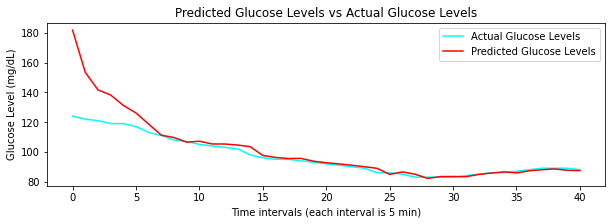

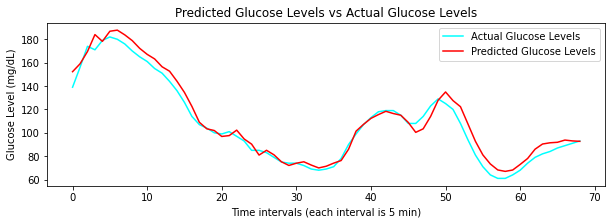

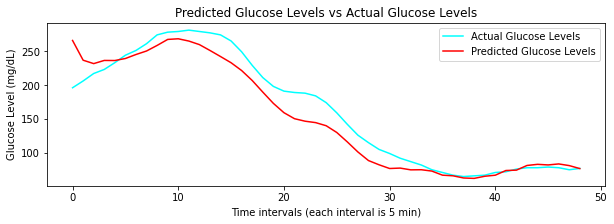

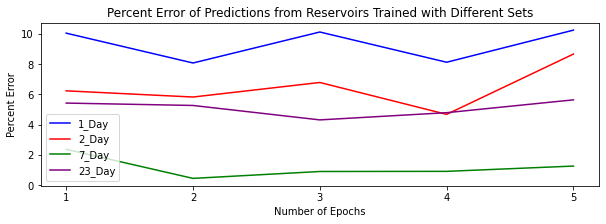

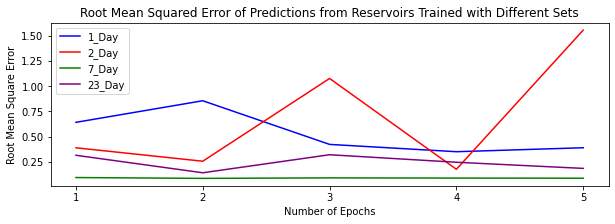



RMSE_7_2epoch:  0.08653977260647235
error_7_2epoch:  [0.44419745]


In [ ]:
Pt1_Training_Group.Test_All()

In [ ]:

Pt2_Data_Set = Data_Processor('Proj_1_Data/552-ws-training.xml')
Pt2_Data_Set.Read_Raw_Data()
Pt2_Data_Set.Process_Raw_Data()
#Pt2_Data_Set.Graph_Single_Date()
print("\n\n\n\n____________________________________________________________________________________________\n\n")


Pt2_Reservoir = Train_Pt_2_Reservoir(Pt2_Data_Set.complete_time_set, Pt2_Data_Set.complete_glucose_set)





____________________________________________________________________________________________




In [ ]:
Pt2_Reservoir.Train_pt2()

Printing graph depicting day 0 of test_set predicted and actual glucose values


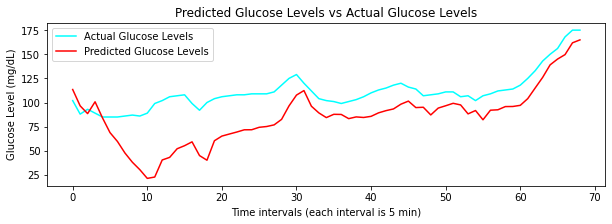

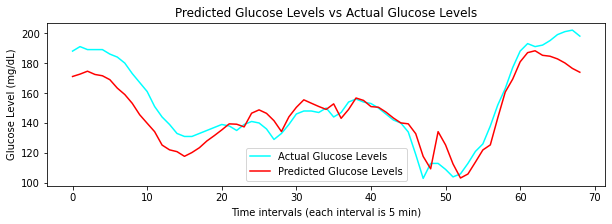

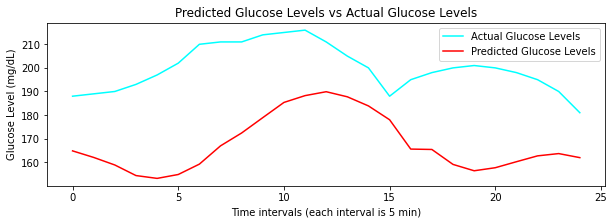

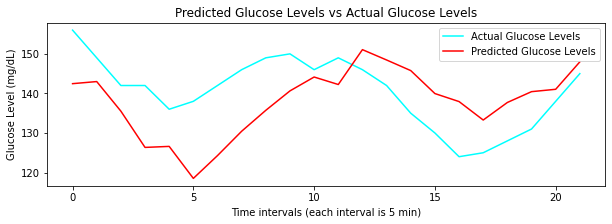



av_rmse:  0.14250363610209926
av_error:  [7.63343565]


In [ ]:
Pt2_Reservoir.Test_pt2()